In [302]:
import pandas as pd
from datetime import datetime, timedelta

import numpy as np
from scipy.special import expit

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
toys = pd.read_csv('amazon_reviews_us_Toys_v1_00.tsv', sep='\t', error_bad_lines=False)

print('Data frame shape with error rows removed:', toys.shape)

filepath = 'amazon_reviews_us_Toys_v1_00.tsv'
with open(filepath) as fp:
    lines = fp.readlines()
    
print('Total number of lines in the file:', len(lines))

print('Precentage of rows missing',1-toys.shape[0] / len(lines))

# Not a significant numebr of rows lost by ignoring the rows with errors

toys.review_date = pd.to_datetime(toys.review_date, format='%Y-%m-%d')

toys = toys[toys.review_date >= datetime(2014, 1, 1)]

print('Data frame filterd down to 2014-2015', toys.shape)

b'Skipping line 7003: expected 15 fields, saw 22\nSkipping line 22430: expected 15 fields, saw 22\nSkipping line 25418: expected 15 fields, saw 22\nSkipping line 43786: expected 15 fields, saw 22\nSkipping line 46566: expected 15 fields, saw 22\nSkipping line 63511: expected 15 fields, saw 22\n'
b'Skipping line 69097: expected 15 fields, saw 22\nSkipping line 74615: expected 15 fields, saw 22\nSkipping line 79354: expected 15 fields, saw 22\nSkipping line 81566: expected 15 fields, saw 22\nSkipping line 89464: expected 15 fields, saw 22\nSkipping line 93104: expected 15 fields, saw 22\nSkipping line 95570: expected 15 fields, saw 22\nSkipping line 96587: expected 15 fields, saw 22\nSkipping line 102117: expected 15 fields, saw 22\nSkipping line 121288: expected 15 fields, saw 22\n'
b'Skipping line 144424: expected 15 fields, saw 22\nSkipping line 168191: expected 15 fields, saw 22\nSkipping line 173291: expected 15 fields, saw 22\n'
b'Skipping line 199932: expected 15 fields, saw 22\nS

b'Skipping line 1424679: expected 15 fields, saw 22\nSkipping line 1432808: expected 15 fields, saw 22\nSkipping line 1433856: expected 15 fields, saw 22\nSkipping line 1441326: expected 15 fields, saw 22\n'
b'Skipping line 1456069: expected 15 fields, saw 22\nSkipping line 1459027: expected 15 fields, saw 22\nSkipping line 1472997: expected 15 fields, saw 22\nSkipping line 1473385: expected 15 fields, saw 22\nSkipping line 1477354: expected 15 fields, saw 22\nSkipping line 1484134: expected 15 fields, saw 22\nSkipping line 1485917: expected 15 fields, saw 22\nSkipping line 1487630: expected 15 fields, saw 22\nSkipping line 1492663: expected 15 fields, saw 22\nSkipping line 1498469: expected 15 fields, saw 22\nSkipping line 1506187: expected 15 fields, saw 22\n'
b'Skipping line 1510623: expected 15 fields, saw 22\nSkipping line 1514521: expected 15 fields, saw 22\nSkipping line 1522642: expected 15 fields, saw 22\nSkipping line 1533051: expected 15 fields, saw 22\nSkipping line 1537618

Data frame shape with error rows removed: (4859607, 15)
Total number of lines in the file: 4864250
Precentage of rows missing 0.0009545150845453598


In [92]:
%matplotlib inline

In [95]:
toys.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18778586,RDIJS7QYB6XNR,B00EDBY7X8,122952789,Monopoly Junior Board Game,Toys,5.0,0.0,0.0,N,Y,Five Stars,Excellent!!!,2015-08-31
1,US,24769659,R36ED1U38IELG8,B00D7JFOPC,952062646,56 Pieces of Wooden Train Track Compatible wit...,Toys,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31
2,US,44331596,R1UE3RPRGCOLD,B002LHA74O,818126353,Super Jumbo Playing Cards by S&S Worldwide,Toys,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31
3,US,23310293,R298788GS6I901,B00ARPLCGY,261944918,Barbie Doll and Fashions Barbie Gift Set,Toys,5.0,0.0,0.0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31
4,US,38745832,RNX4EXOBBPN5,B00UZOPOFW,717410439,Emazing Lights eLite Flow Glow Sticks - Spinni...,Toys,1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31


# MVP

Select 10000 random products and build a quick prototype to see get the workflow for predicting trending.

In [327]:
products = toys.product_id.unique()
rand_products = np.random.choice(products, size=10000, replace=False)
products_df = toys[toys.product_id.isin(rand_products)]

# Get all reviews within 1 month.

last_review = products_df.groupby('product_id')['review_date'].max().reset_index()
products_df = products_df.merge(last_review, how='inner', on='product_id')

products_df.rename(columns={'review_date_x':'review_date', 'review_date_y':'max_review_date'}, inplace=True)

reviews_one_month_df = products_df[products_df.max_review_date - products_df.review_date < timedelta(days=30)]

# Calculate the trending metric
reviews_one_month_df['adj_star_rating'] = reviews_one_month_df['star_rating'].astype(float) ** 1.5
prod_review_stats_df = reviews_one_month_df.groupby('product_id')['adj_star_rating'].agg(['count','mean','std'])
prod_review_stats_df['orig_std'] = prod_review_stats_df['std']


# if NA then use the std of the median variance
prod_review_stats_df.loc[prod_review_stats_df['std'] == 0, 'std'] = np.nan
na_std = prod_review_stats_df['std'].min()
prod_review_stats_df['std'].fillna(na_std, inplace=True)

# could add a power here to better differentiate 
prod_review_stats_df['review_proportion'] = prod_review_stats_df['count'] / prod_review_stats_df['count'].sum()

prod_review_stats_df['review_success'] = (
    (prod_review_stats_df['review_proportion'] * prod_review_stats_df['mean'])
    / (prod_review_stats_df['std'])
)

# logistic (0.5 - 1, since review success will be positive)
prod_review_stats_df['rating_factor_logit'] = expit(prod_review_stats_df['review_success'])

# tanh (0 - 1 since review success will be positive)
prod_review_stats_df['rating_factor_tanh'] = np.tanh(prod_review_stats_df['review_success'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Let's now make sure the top 10 in terms of the rating socre makes sense.

In [328]:
prod_review_stats_df.sort_values('rating_factor_tanh', ascending=False).head(10)

,count,mean,std,orig_std,review_proportion,review_success,rating_factor_logit,rating_factor_tanh
product_id,,,,,,,,
B00JKNRYPM,21,11.028895,0.694007,0.694007,0.001528,0.024281,0.506070,0.024277
B00M4E5XD4,25,10.925913,0.880596,0.880596,0.001819,0.022569,0.505642,0.022565
B000STFRDI,18,11.180340,0.694007,0.000000,0.001310,0.021098,0.505274,0.021095
B00JLHVX36,48,10.417872,1.777290,1.777290,0.003492,0.020471,0.505118,0.020469
B000IZ9N78,76,9.740796,2.744408,2.744408,0.005530,0.019627,0.504907,0.019624
B00CQHYWLS,17,10.993261,0.771346,0.771346,0.001237,0.017628,0.504407,0.017627
B00IYDM814,32,10.720571,1.638441,1.638441,0.002328,0.015234,0.503809,0.015233
B00MJ8F22M,11,11.180340,0.694007,0.000000,0.000800,0.012893,0.503223,0.012893
B0016DE80I,8,11.180340,0.694007,0.000000,0.000582,0.009377,0.502344,0.009377


Some of the reviews with all 5 start ratings, i.e. 11.18, are appearing in the top 10 with a high number of reviews. This appears to be a pretty reasonable ranking score. Now let's get the top 1% in terms of the ranking score.

In [331]:
prod_review_stats_df.rating_factor_tanh.quantile(0.99)

0.004544969264926689

In [337]:
top_1_p = (prod_review_stats_df[
    prod_review_stats_df['rating_factor_tanh']
    > prod_review_stats_df.rating_factor_tanh.quantile(0.99)]
          )

top_1_p.describe()

,count,mean,std,orig_std,review_proportion,review_success,rating_factor_logit,rating_factor_tanh
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9.230000,10.925889,1.011157,0.476772,0.000672,0.006708,0.501677,0.006708
std,10.769256,0.683739,0.753243,0.997958,0.000784,0.004008,0.001002,0.004008
min,4.000000,7.152083,0.694007,0.000000,0.000291,0.004582,0.501145,0.004582
25%,4.000000,11.180340,0.694007,0.000000,0.000291,0.004689,0.501172,0.004689
50%,5.000000,11.180340,0.694007,0.000000,0.000364,0.005582,0.501395,0.005582
75%,8.000000,11.180340,0.694007,0.000000,0.000582,0.006895,0.501724,0.006895
max,76.000000,11.180340,4.542981,4.542981,0.005530,0.024281,0.506070,0.024277


Let's look at the product with the lowest mean rating.

In [344]:
top_1_p.sort_values('mean').head(1)

,count,mean,std,orig_std,review_proportion,review_success,rating_factor_logit,rating_factor_tanh
product_id,,,,,,,,
B00U2UO2G6,40,7.152083,4.542981,4.542981,0.00291,0.004582,0.501145,0.004582


In [347]:
top_1_p.sort_values('mean').head(1)['mean'] ** (1/1.5)

product_id
B00U2UO2G6    3.712117
Name: mean, dtype: float64

The lowest rated product is in 3.7 star rating range, but highly reviewed. This is a sub-sample of 1000 products, so it could be filtered out in a larger more robust sample of products. This rating is above average, and we are effectively filtering out the highlight negative reviewed products, which is the goal.

### Create the observation data set

In [353]:
prod_review_stats_df['trend'] = (prod_review_stats_df['rating_factor_tanh']
                                    > prod_review_stats_df.rating_factor_tanh.quantile(0.99)
                                ).astype(int)

obs = prod_review_stats_df.reset_index()
obs = obs.loc[:,['product_id', 'trend']]

Get the first review for each product from the one month data frame.

In [363]:
first_review_df = reviews_one_month_df.groupby('product_id')['review_date'].min().reset_index()
first_review_df = first_review_df.merge(
                    reviews_one_month_df, 
                    on = ['product_id','review_date'],
                    how = 'inner')
obs = obs.merge(first_review_df.loc[:,['product_id','review_headline', 'review_body']], 
                   on='product_id')

In [365]:
obs.head()

,product_id,trend,review_headline,review_body
0,0641832613,0,My daughter LOVES Mistletoe but this price mus...,Adorable! My daughter loves Mistletoe! She g...
1,069221657X,0,You will love this Red Box,If you are a fan of the old D&D Red Box... You...
2,0735323364,0,"These are reasonably priced, encourage imagina...","These are reasonably priced, encourage imagina..."
3,0735327696,0,"Hours, no DAYS of entertainment","Has provided hours, no DAYS of entertainment f..."
4,0735329699,0,Temporary Fun,Got this for a road trip so we could have a po...


Perform train / test split and will only use `review_body` for the interim.

In [381]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

obs.dropna(inplace=True) # 2 reivew bodys with nothing
obs['review_body'] = obs.review_body.map(alphanumeric).map(punc_lower)
obs.head()

,product_id,trend,review_headline,review_body
0,0641832613,0,My daughter LOVES Mistletoe but this price mus...,adorable my daughter loves mistletoe she g...
1,069221657X,0,You will love this Red Box,if you are a fan of the old d d red box you...
2,0735323364,0,"These are reasonably priced, encourage imagina...",these are reasonably priced encourage imagina...
3,0735327696,0,"Hours, no DAYS of entertainment",has provided hours no days of entertainment f...
4,0735329699,0,Temporary Fun,got this for a road trip so we could have a po...


In [382]:
X = obs.review_body
y = obs.trend

In [384]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [385]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,aa,aaa,aaaaa,aaaaaa,aaron,ab,abacus,abandoned,abbey,abby,...,zoids,zombie,zombies,zombiezoo,zone,zones,zoo,zookeepers,zooms,zulilly
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Try Logistic Regression

In [386]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_train_cv1)

In [387]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

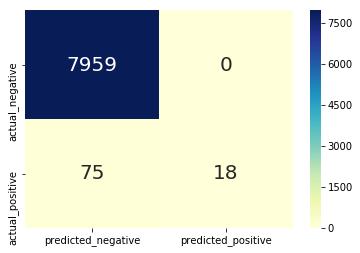

In [389]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_train, y_pred_cv1)

In [390]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(cm1))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1']
results

,LogReg1
Accuracy,0.991
Precision,1.000
Recall,0.194
F1 Score,0.325


Accuracy is the same as if the negative is predicted for the entire data set. However, recall is better. There is some predictive power with a simple model. The question is whether or not the following will help.

* Hyper-tuning parameters
* Other dtm transformations
* Sampling processes


** Should really build a class to allow for quick running of these different experiments **

** Some products duplicated beacuse multiple reviews on the same day, which needs to be cleaned or combined **